In [42]:
# Install and import module for a visualization of the computational graph
!pip install torchviz
from torchviz import make_dot

In [43]:
# Import the torch module
import torch

# Getting Data

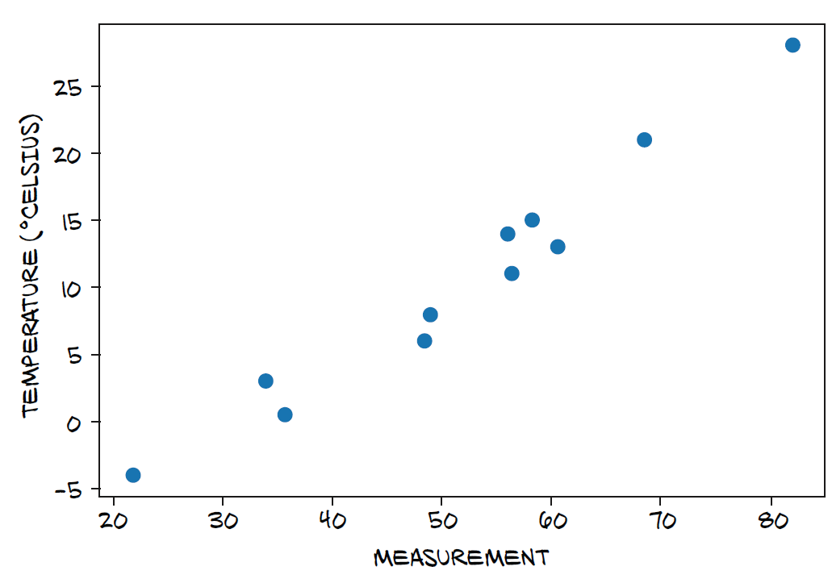

We would like to analyze the relationship between temperature data in good old Celsius and measurements from a new thermometer.

In [44]:
# Data
t_c = torch.tensor([0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])

# Choose a Machine Learning Model

We’ll start by choosing a linear model to analyze the relationship between temperature data in good old Celsius and measurements from a new thermometer.
> - The **linear regression model** is
$t_c = w * t_u + b$
where $w$ and $b$ are weight and bias, which are two very common terms for linear scaling and the additive constant.
>-  The **objective of learning** is to estimate w and b, the parameters in our model, based on the data we have. We must do it so that temperatures we obtain from running the unknown temperatures t_u through the model are close to temperatures we actually measured in Celsius.

In [45]:
# Let’s write out the Linear Regression model as a Python function:
def model(t_u, w, b):
    return w * t_u + b

# Loss Function

We have a model with some unknown parameters, and we need to estimate those parameters so that the error between predicted outputs and measured values is as low as possible.

To this end, we need to exactly define a measure of the error. Such a measure, which we refer to as the **loss function**, should be high if the error is high and should ideally be as low as possible for a perfect match.

The calculation of loss typically involves taking the difference between the desired outputs for some training samples and the outputs actually produced by the model when fed those samples.
> - Mean Square of the differences: $L = mean((t_p – t_c)^2)$, or
> - Mean Absolute value of the differences: $L = mean(|t_p – t_c|)$


Less loss is what we want!

In [46]:
# Let's define our loss function
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c) ** 2
    return squared_diffs.mean()

t_p--> tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000], grad_fn=<AddBackward0>)

loss--> tensor(1763.8848, grad_fn=<MeanBackward0>)


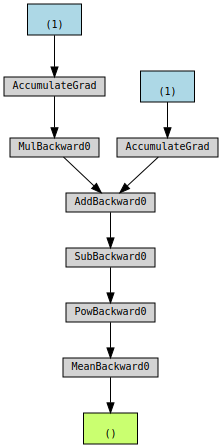

In [56]:
# We can now initialize the parameters, invoke the model
w = torch.ones((1,), requires_grad=True )
b = torch.zeros((1,), requires_grad=True)

t_p = model(t_u, w, b)
print('t_p-->', t_p)
print()

# check the value of the loss
loss = loss_fn(t_p, t_c)
print('loss-->', loss)

# visualize computational graph
make_dot(loss)

# Optimizer : Down along the gradient!

Our optimization process should therefore aim at finding $w$ and $b$ so that the $loss function$ is at a minimum.

We’ll optimize the loss function with respect to the parameters using the **gradient descent algorithm**
> - The idea is to compute the partial derivative of the loss (the rate of change of the loss) with respect to each parameter (weight and bias), and modify each parameter in the direction of decreasing loss

This is saying that in the neighborhood of the current values of $w$ and $b$, a unit increase in $w$ leads to some change in the loss. If the change is negative, then we need to increase $w$ to minimize the loss, whereas if the change is positive, we need to decrease $w$.

**The gradient of the loss is the vector of partial derivatives with respect to the parameters**

$
\nabla L(\left.w, b\right)=\left[\begin{array}{c}
\dfrac{\partial L}{\partial w}(\left.w, b\right)\\
\dfrac{\partial L}{\partial b}(\left.w, b\right) \\
\end{array}\right]
$

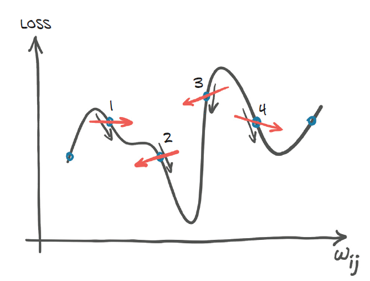


**Based on chain rule:**

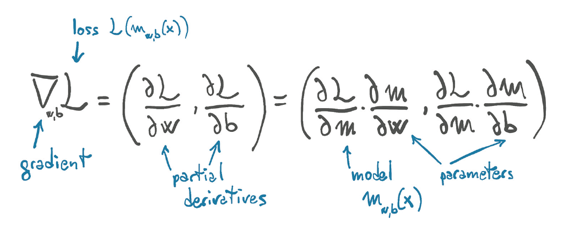

## Compute the Gradient (Based on Manually Derived Forms)

In [48]:
# define the partial derivative of the loss with respect to the model function
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # The division is from the derivative of mean
    return dsq_diffs

# define the partial derivative of the loss with respect to the weight w. Note the closed-form of the partial derivative is manually derived, not via auto-grad
def dmodel_dw(t_u, w, b):
    return t_u   # because the linear regression model we used here has the form of  t_c = w * t_u + b, so the partial derivative

# define the partial derivative of the loss with respect to the weights b.
def dmodel_db(t_u, w, b):
    return 1.0

# define the gradient of the loss with respect to the parameters, based on the chain rule given in the image above
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])   # form the gradient vector

## The Training Loop

An **epoch** is a training iteration during which we update the parameters for all of our training samples

In [49]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)     #   note: forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)   # note: backward pass

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            print('    Params:', params)
            print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')
    return params

# Starting Training

## Training may come with some issues, for example,
> - **learning rate** may be too large or too small.
>> The following example has a large learning rate value which leads to losses becoming inf.
> - **data** may have varying scales
>> - The following example shows the first-epoch gradient for the weight is about 50 times larger than the gradient for the bias; This means that the weight and bias live in differently scaled
spaces. If this is the case, a learning rate that’s large enough to meaningfully update one will be so large as to be unstable for the other; and a rate that’s appropriate for the other won’t be large enough to meaningfully change the first.
>>  - A simple solution (normalizing inputs or feature scaling) is to change the inputs so that the gradients aren’t quite so different. We can make sure the range of the input doesn’t get too far from the range of –1.0 to 1.0, roughly speaking. In our case, we can achieve something close enough to that by simply multiplying t_u by 0.1: $t_un = 0.1 * t_u$

In [50]:
params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])
...
Epoch 99, Loss nan
    Params: tensor([nan, nan])
    Grad:   tensor([nan, nan])
Epoch 100, Loss nan
    Params: tensor([nan, nan])
    Grad:   tensor([nan, nan])
...
Epoch 4000, Loss nan
    Params: tensor([nan, nan])
    Grad:   tensor([nan, nan])
Epoch 5000, Loss nan
    Params: tensor([nan, nan])
    Grad:   tensor([nan, nan])


## Use an appropriate learning rate

we test by using learning_rate = 1e-4 instead of learning_rate = 1e-2

In [51]:
params =training_loop(n_epochs = 5000, learning_rate = 1e-4, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])
...
Epoch 4000, Loss 25.691162
    Params: tensor([ 0.2528, -1.1832])
    Grad:   tensor([-0.0496,  2.8231])
Epoch 5000, Loss 24.907743
    Params: tensor([ 0.2577, -1.4631])
    Grad:   tensor([-0.0488,  2.7741])


## Normalizing inputs

We analyze by using the normalized data **t_un** and **t_c**, instead of the original **t_u** and **t_c**.

Here **t_un = 0.1 * t_u**, so the range of the input doesn’t get too far from the range of –1.0 to 1.0, roughly speaking.

from below, we may notice that even though we set our learning rate back to 1e-2, parameters don’t blow up during iterative updates. Let’s take a look at the gradients: they’re of similar magnitude, so using a single learning_rate for both parameters works just fine

In [52]:
t_un = 0.1 * t_u

params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])


# Visualizing the Regression Result

Using a plot of our linear-fit model (solid line) versus our input data (circles)

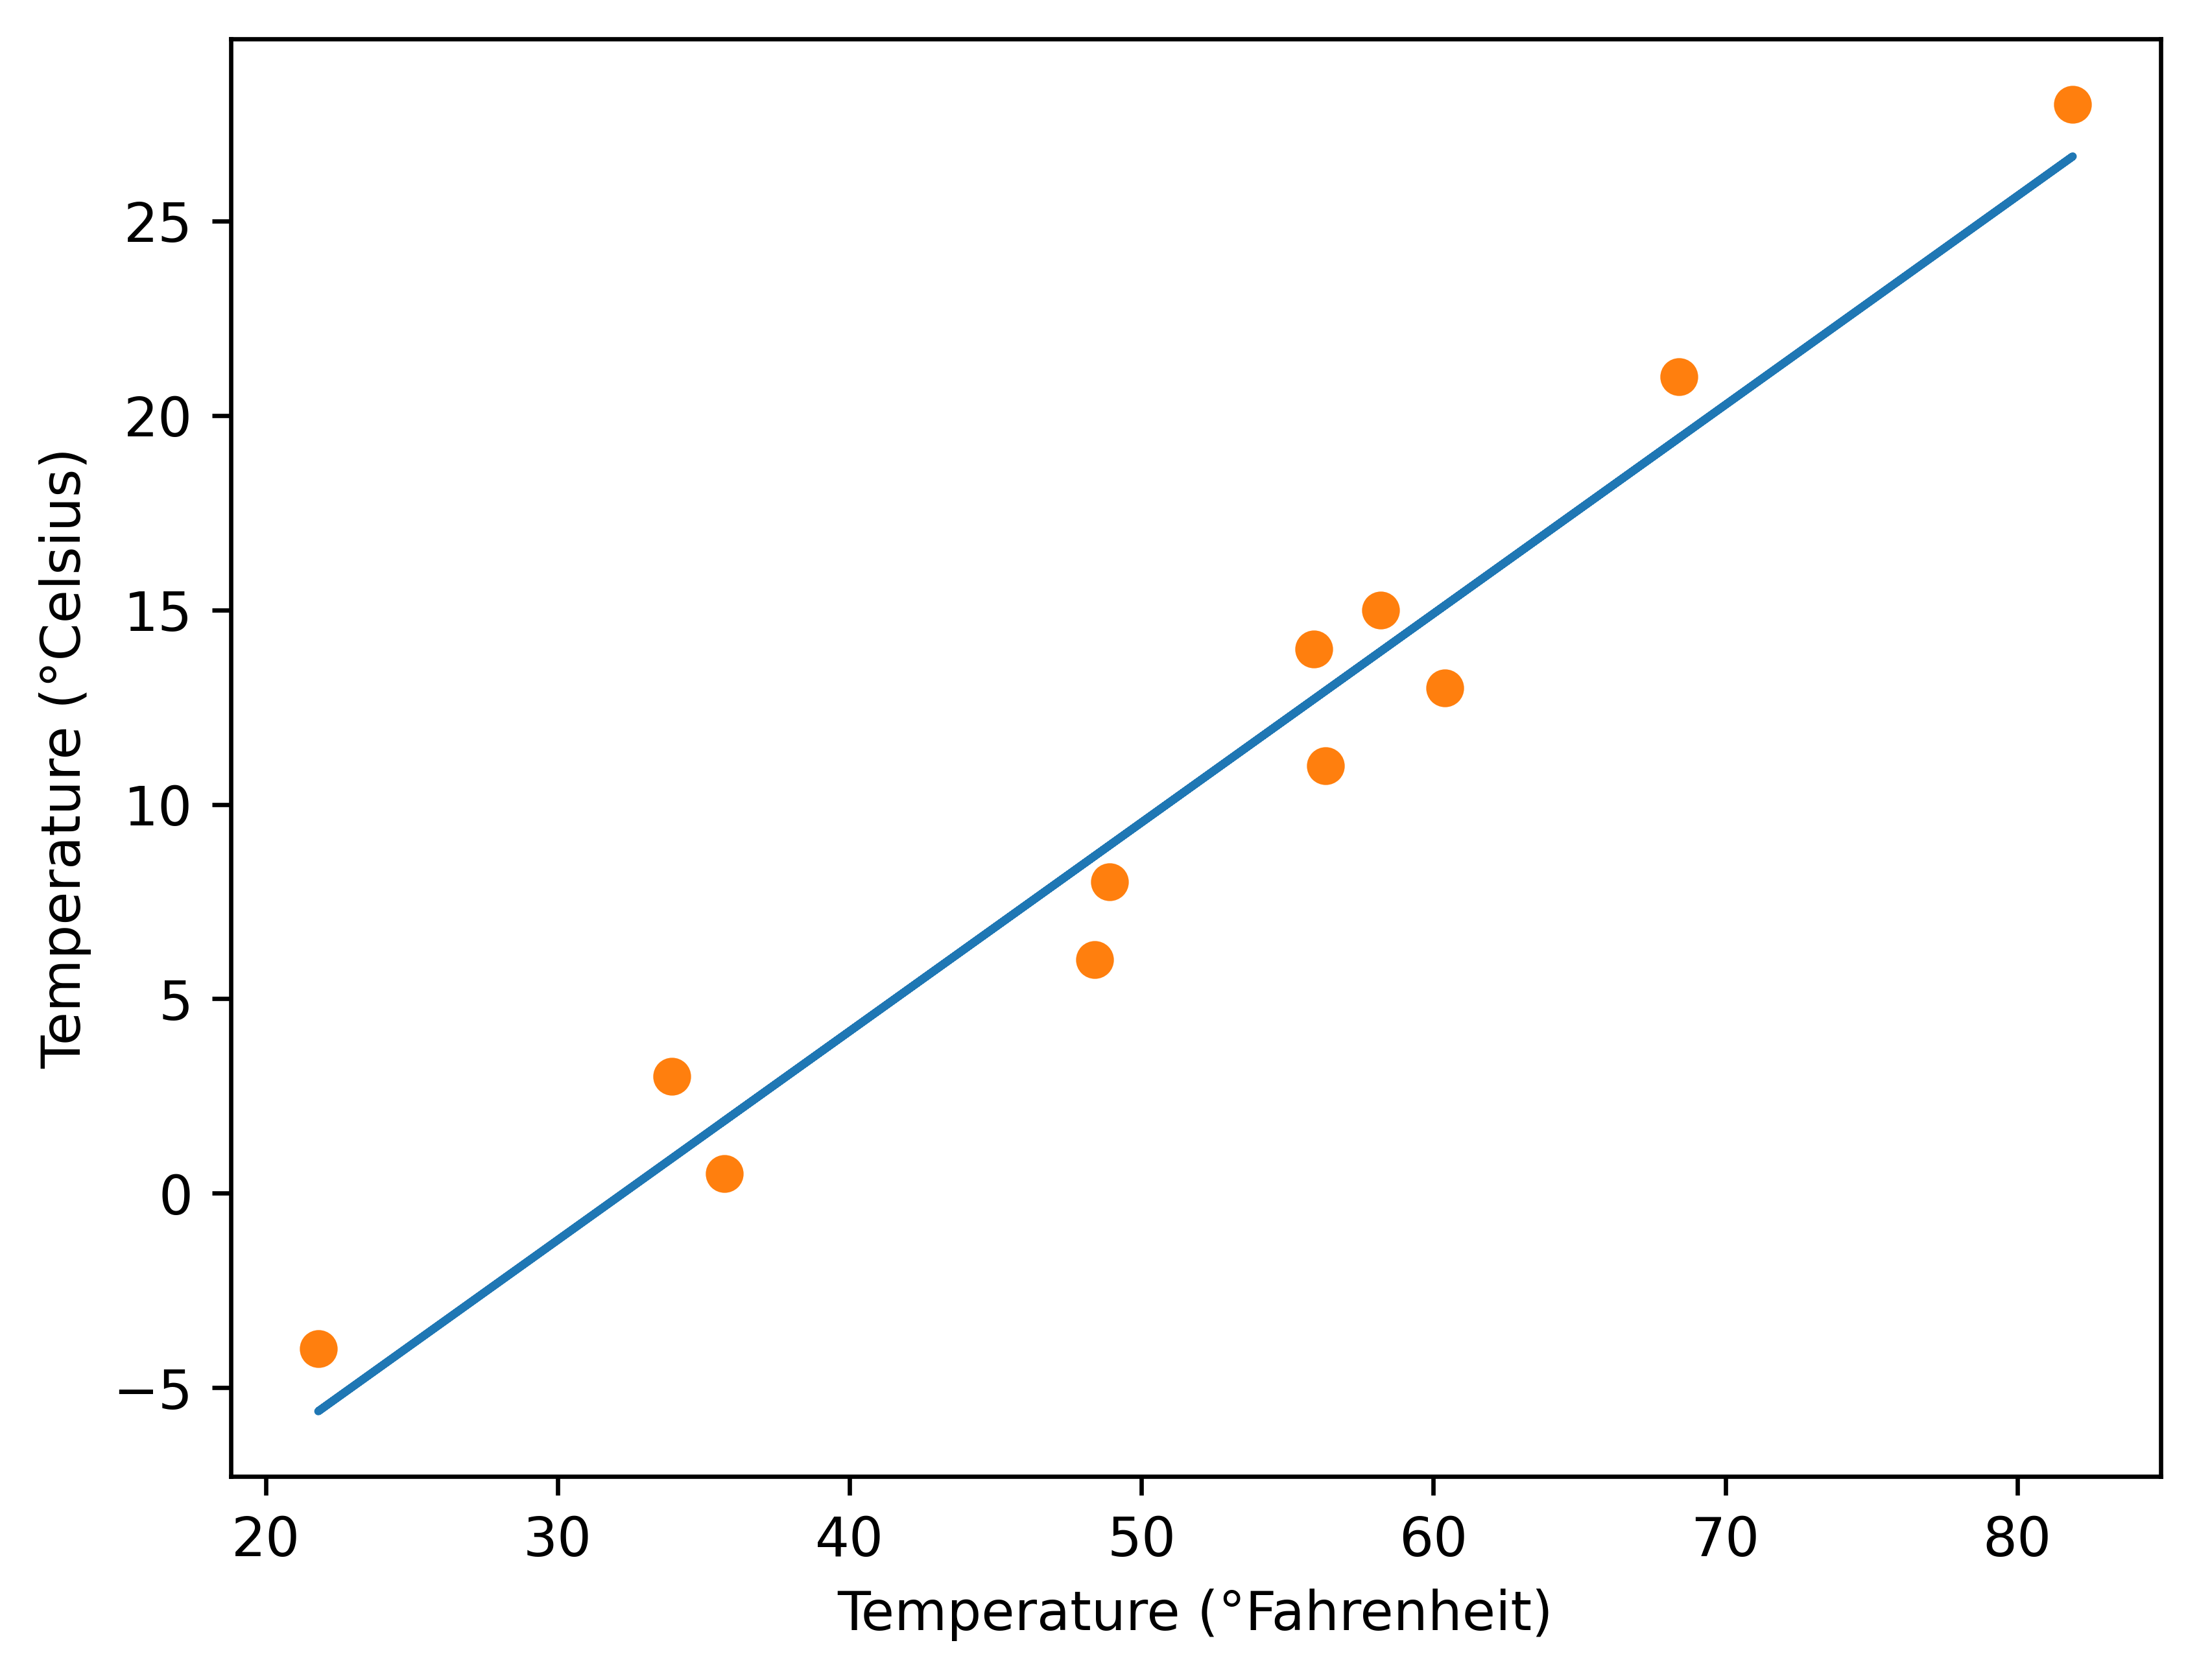

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, params[0], params[1])

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())   # as t_p is a tensor computed, we detach it from the current graph before converting to numpy array, check https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")